<a href="https://colab.research.google.com/github/aimalz/CASTORpz/blob/main/plottingSEDs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import astropy.constants as const

import matplotlib.pyplot as plt
import numpy as np
import h5py 

# from surveys import Filter
# import igm
# from castor_etc.conversions import flam_to_AB_mag, fnu_to_flam


In [3]:
cd ..

/Users/bryan/Downloads


In [4]:
##############################################
#READ CATALOG MADE IN Process_COSMOS.ipynb
##############################################

cat = Table.read('COSMOS2020_Farmer_processed.fits', format='fits', hdu=1)

In [5]:
cat.info

<Table length=698211>
       name        dtype     unit      class     n_bad 
----------------- ------- --------- ------------ ------
               ID   int64           MaskedColumn      0
               RA float64       deg       Column      0
              DEC float64       deg       Column      0
      CFHT_u_FLUX float64 erg / cm2 MaskedColumn  38399
   CFHT_u_FLUXERR float64 erg / cm2 MaskedColumn  38399
       HSC_g_FLUX float64 erg / cm2 MaskedColumn   2057
    HSC_g_FLUXERR float64 erg / cm2 MaskedColumn   2057
       HSC_r_FLUX float64 erg / cm2 MaskedColumn   1562
    HSC_r_FLUXERR float64 erg / cm2 MaskedColumn   1562
       HSC_i_FLUX float64 erg / cm2 MaskedColumn   1264
    HSC_i_FLUXERR float64 erg / cm2 MaskedColumn   1264
       HSC_z_FLUX float64 erg / cm2 MaskedColumn    880
    HSC_z_FLUXERR float64 erg / cm2 MaskedColumn    880
       HSC_y_FLUX float64 erg / cm2 MaskedColumn   1031
    HSC_y_FLUXERR float64 erg / cm2 MaskedColumn   1031
    UVISTA_Y_FLUX float64 

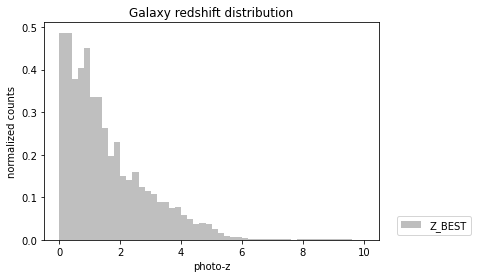

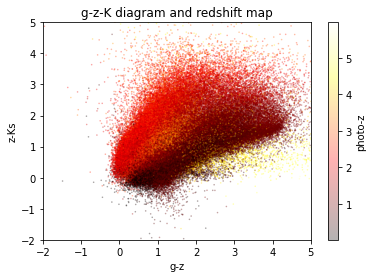

In [ ]:
plt.hist(cat['photoz'],range=(0.01,10),log=False,bins=50,density=True,color ='grey',alpha=0.5,label = 'Z_BEST')
#plt.hist(cat['lp_zp_2'],range=(0.01,10),log=False,bins=50,density=True,color ='orange',histtype='step',label = 'Z_SEC')
#plt.hist(cat['lp_zq'][cat['lp_type']==2],range=(0.01,10),log=False,bins=50,density=True,color ='blue',alpha=0.5,label = 'Z_AGN',histtype='step')
plt.title('Galaxy redshift distribution')
plt.xlabel('photo-z')
plt.ylabel('normalized counts')
plt.legend(bbox_to_anchor=(1.04,0),loc='lower left')
plt.show()

color1 = cat['HSC_g_MAG'] - cat['HSC_z_MAG']
color2 = cat['HSC_z_MAG'] - cat['UVISTA_Ks_MAG']
zmap = cat['photoz']
sel = (cat['photoz']>=0.) & (cat['photoz']<6.) & (cat['UVISTA_Ks_MAG']<24.5)
plt.scatter(color1[sel],color2[sel],c=zmap[sel],cmap='hot',s=0.4,alpha=0.3)
plt.xlim(-2,5)
plt.ylim(-2,5)
cbar=plt.colorbar()
cbar.set_label('photo-z')
plt.xlabel('g-z')
plt.ylabel('z-Ks')

plt.title('g-z-K diagram and redshift map')
plt.show()

In [10]:
# now work with bc03 models
hdf = h5py.File("COSMOS2020_LePhare_v2_20210507_LIB_COMB.hdf5","r")

In [12]:
# we need this to compute luminosity distances
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
# note that COSMOS2020 SED fitting assumes 'vanilla' cosmology

In [8]:
def dust_ext(w, law=0, ebv=0.):
    # copied from cosmos tutorial notebook
    law1 = np.loadtxt("COSMOS2020_R1\SB_calzetti.dat").T
    law2 = np.loadtxt("COSMOS2020_R1\extlaw_0.9.dat").T
    ext_w = [law1[0],law2[0]]
    ext_k = [law1[1],law2[1]]
    if ebv>0.:
        k = np.interp(w,ext_w[law],ext_k[law])
        return np.power(10.,-0.4*ebv*k)
    else:
        return 1.

In [9]:
orig_filters = [Filter("FTCs/GALEX_GALEX.NUV.dat", name="GALEX_NUV"),
                Filter("FTCs/CFHT_MegaCam.u.dat", name="CFHT_u"),
                Filter("FTCs/Subaru_HSC.g.dat", name="HSC_g"),
                Filter("FTCs/Subaru_HSC.r.dat", name="HSC_r"),
                Filter("FTCs/Subaru_HSC.i.dat", name="HSC_i"),
                Filter("FTCs/Subaru_HSC.z.dat", name="HSC_z"),
                Filter("FTCs/Subaru_HSC.Y.dat", name="HSC_y"),
                Filter("FTCs/Paranal_VISTA.Y.dat", name="UVISTA_Y"),
                Filter("FTCs/Paranal_VISTA.J.dat", name="UVISTA_J"),
                Filter("FTCs/Paranal_VISTA.H.dat", name="UVISTA_H"),
                Filter("FTCs/Paranal_VISTA.Ks.dat", name="UVISTA_Ks"),
                Filter("FTCs/Spitzer_IRAC.I1.dat", name="IRAC_CH1"),
                Filter("FTCs/Spitzer_IRAC.I2.dat", name="IRAC_CH2"),
               ]

og_dict = {}
for f in orig_filters:
    og_dict[f.name] = f

roman_area = np.pi * (2.36 / 2)**2
mock_filters = [Filter("FTCs/passband_castor.uv", name="castor_uv", wlunit=u.um),
                Filter("FTCs/passband_castor.u", name="castor_u", wlunit=u.um),
                Filter("FTCs/passband_castor.g", name="castor_g", wlunit=u.um),
                #Filter("FTCs/passband_castor.uv_split_bb", name="castor_uv_split_bb", wlunit=u.um),
                #Filter("FTCs/passband_castor.u_split_bb", name="castor_u_split_bb", wlunit=u.um),
                #Filter("FTCs/passband_castor.uv_split_lp", name="castor_uv_split_lp", wlunit=u.um),
                #Filter("FTCs/passband_castor.u_split_lp", name="castor_u_split_lp", wlunit=u.um),
                Filter("FTCs/LSST_LSST.u.dat", name="LSST_u"),
                Filter("FTCs/LSST_LSST.g.dat", name="LSST_g"),
                Filter("FTCs/LSST_LSST.r.dat", name="LSST_r"),
                Filter("FTCs/LSST_LSST.i.dat", name="LSST_i"),
                Filter("FTCs/LSST_LSST.z.dat", name="LSST_z"),
                Filter("FTCs/LSST_LSST.y.dat", name="LSST_y"),
                Filter("FTCs/PAN-STARRS_PS1.g.dat", name="PanStarrs_g"),
                Filter("FTCs/PAN-STARRS_PS1.r.dat", name="PanStarrs_r"),
                Filter("FTCs/PAN-STARRS_PS1.i.dat", name="PanStarrs_i"),
                Filter("FTCs/PAN-STARRS_PS1.z.dat", name="PanStarrs_z"),
                Filter("FTCs/PAN-STARRS_PS1.y.dat", name="PanStarrs_y"),
                Filter("FTCs/NISP-PHOTO-PASSBANDS-V1-Y_throughput.txt", name="Euclid_Y", wlunit = u.nm),
                Filter("FTCs/NISP-PHOTO-PASSBANDS-V1-J_throughput.txt", name="Euclid_J", wlunit = u.nm),
                Filter("FTCs/NISP-PHOTO-PASSBANDS-V1-H_throughput.txt", name="Euclid_H", wlunit = u.nm),
                Filter("FTCs/Euclid_VIS.vis.dat", name="Euclid_VIS"),
                #Filter("FTCs/WFIRST_WFI.R062.dat", name="Roman_R"),
                #Filter("FTCs/WFIRST_WFI.Z087.dat", name="Roman_Z")
                #Filter("FTCs/WFIRST_WFI.Y106.dat", name="Roman_Y"),
                #Filter("FTCs/WFIRST_WFI.J129.dat", name="Roman_J"),
                #Filter("FTCs/WFIRST_WFI.H158.dat", name="Roman_H"),
                #Filter("FTCs/WFIRST_WFI.F184.dat", name="Roman_K")
                Filter("FTCs/Roman_WFI.F062.dat", name="Roman_062", wlunit=u.um, response_scale=roman_area),
                Filter("FTCs/Roman_WFI.F087.dat", name="Roman_087", wlunit=u.um, response_scale=roman_area),
                Filter("FTCs/Roman_WFI.F106.dat", name="Roman_106", wlunit=u.um, response_scale=roman_area),
                Filter("FTCs/Roman_WFI.F129.dat", name="Roman_129", wlunit=u.um, response_scale=roman_area),
                Filter("FTCs/Roman_WFI.F146.dat", name="Roman_146", wlunit=u.um, response_scale=roman_area),
                Filter("FTCs/Roman_WFI.F158.dat", name="Roman_158", wlunit=u.um, response_scale=roman_area),
                Filter("FTCs/Roman_WFI.F184.dat", name="Roman_184", wlunit=u.um, response_scale=roman_area),
                Filter("FTCs/Roman_WFI.F213.dat", name="Roman_213", wlunit=u.um, response_scale=roman_area)
               ]

mock_dict = {}
for f in mock_filters:
    mock_dict[f.name] = f

NameError: name 'Filter' is not defined

In [10]:
# figure out which orig filters to use for each new filter
# could possibly use more than one nearby filter and take weighted average

for f in mock_filters:
    nearby = []
    if f.center < 12000:
        close_wl = 1500
    else:
        close_wl = 4000

    for g in orig_filters:
        if np.abs(f.center - g.center) <= close_wl:
            nearby.append(g.name)
    f.nearby = nearby
    print(f.name, f.nearby)

NameError: name 'mock_filters' is not defined

In [5]:
cat['ID'] 

1
2
3
5
6
7
12
17
18
19
20


In [20]:
np.where(cat['ID']==501542)

(array([352349]),)

5
The COSMOS fitted model is model number 5
The offset applied is 300199422.4604483 and a redshift of 0.0651
9
The COSMOS fitted model is model number 9
The offset applied is 356618805.57875204 and a redshift of 0.0995


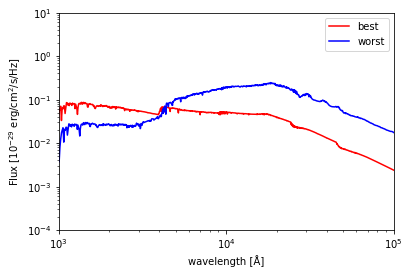

In [17]:
id_gal = 147 # the ID number of the galaxy you want to plot; IDs are different for Farmer and Classic
nid = np.where(cat['ID']==id_gal)[0][0]

# # wl_obs = np.array([f.center for f in orig_filters])  # wavelength center of the filter used
# wl_obserr = np.array([f.max_wl - f.min_wl for f in orig_filters])/2.
# fnu_obs = np.array([cat[f.name + '_FLUX'][nid] for f in orig_filters]) # Reads the measured magnitude at that wavelength
# fnu_obserr = np.array([cat[f.name + '_FLUXERR'][nid] for f in orig_filters]) #Magnitude associated +/-error
# sel = fnu_obs>0.


plt.ylabel('Flux [$10^{-29}$ erg/cm$^2$/s/Hz]')
# # plt.errorbar(wl_obs[sel],fnu_obs[sel]*1e29,xerr=wl_obserr[sel],yerr=fnu_obserr[sel]*1e29,fmt='.k', ecolor = 'k', capsize=3, elinewidth=1,zorder=2)
# ymin = min(fnu_obs[sel])*1e29*0.5
# ymax = max(fnu_obs[sel]+fnu_obserr[sel])*1e29*6

# Using the redshift of best-fit template
zp = cat['photoz'][nid]
m = int(cat['lp_model'][nid])
print(m)
wvl = hdf['/model{}/spectra'.format(m)].attrs['lambda[AA]'] *u.AA
t = np.abs(hdf['/model{}'.format(m)].attrs['age']-cat['lp_age'][nid]).argmin()
flam_mod = hdf['/model{}/spectra'.format(m)][t,:] *u.erg/u.cm/u.cm/u.s/u.AA
fnu_mod = flam_mod*(wvl**2)/const.c
# Calculates the flux in units of [uJy] also applying dust ext
# fnu_mod = fnu_mod.to(u.erg/u.cm/u.cm/u.s/u.Hz) * dust_ext(wvl.value,law=cat['lp_Attenuation'][nid],ebv=cat['lp_dust'][nid])
# Rescale the template
mscal = hdf['/model{}'.format(m)].attrs['mass'][t]/10**cat['lp_mass_best'][nid]  # luminosity/mass resc
dm = cosmo.luminosity_distance(zp)/(10*u.pc)  # distance modulus
offset = dm.decompose()**2*mscal/(1+zp) # all together * (1+z) factor

# IGM absorption
# IGM_prescription = igm.Inoue14()
# IGM_abs = IGM_prescription.full_IGM(zp, wvl.value * (1 + zp))

# Plot the best-fit model
plt.plot(wvl*(1+zp),fnu_mod.to(u.uJy).value/offset,color='red',alpha=1,label='best',zorder=1)
# plt.plot(wvl*(1+zp),fnu_mod.to(u.uJy).value/offset * IGM_abs,color='blue',alpha=1,label='model',zorder=1)

ymin = 1e-4
ymax = 1e1

# Show where nebular emission lines would potentially boost the flux
# plt.vlines(3727*(1+zp),ymin,ymax,label='[OII]',zorder=0,color='0.3',ls=':')
# plt.vlines(5007*(1+zp),ymin,ymax,label='[OIII]b',zorder=0,color='0.3',ls=':')
# plt.vlines(4861*(1+zp),ymin,ymax,label='Hb',zorder=0,color='0.3',ls=':') # H_beta
# plt.vlines(6563*(1+zp),ymin,ymax,label='Ha',zorder=0,color='0.3',ls=':') # H_alpha


plt.xscale('log')
plt.yscale('log')
plt.xlim(1000,100000)
plt.ylim(ymin,ymax)

# plt.ylim(ymin,ymax)
plt.xlabel('wavelength [Å]')


print("The COSMOS fitted model is model number",m)
print('The offset applied is',offset,'and a redshift of',zp)

id_gal = 4798 # the ID number of the galaxy you want to plot; IDs are different for Farmer and Classic
nid = np.where(cat['ID']==id_gal)[0][0]

# # wl_obs = np.array([f.center for f in orig_filters])  # wavelength center of the filter used
# wl_obserr = np.array([f.max_wl - f.min_wl for f in orig_filters])/2.
# fnu_obs = np.array([cat[f.name + '_FLUX'][nid] for f in orig_filters]) # Reads the measured magnitude at that wavelength
# fnu_obserr = np.array([cat[f.name + '_FLUXERR'][nid] for f in orig_filters]) #Magnitude associated +/-error
# sel = fnu_obs>0.


plt.ylabel('Flux [$10^{-29}$ erg/cm$^2$/s/Hz]')
# # plt.errorbar(wl_obs[sel],fnu_obs[sel]*1e29,xerr=wl_obserr[sel],yerr=fnu_obserr[sel]*1e29,fmt='.k', ecolor = 'k', capsize=3, elinewidth=1,zorder=2)
# ymin = min(fnu_obs[sel])*1e29*0.5
# ymax = max(fnu_obs[sel]+fnu_obserr[sel])*1e29*6

# Using the redshift of best-fit template
zp = cat['photoz'][nid]
m = int(cat['lp_model'][nid])
print(m)
wvl = hdf['/model{}/spectra'.format(m)].attrs['lambda[AA]'] *u.AA
t = np.abs(hdf['/model{}'.format(m)].attrs['age']-cat['lp_age'][nid]).argmin()
flam_mod = hdf['/model{}/spectra'.format(m)][t,:] *u.erg/u.cm/u.cm/u.s/u.AA
fnu_mod = flam_mod*(wvl**2)/const.c
# Calculates the flux in units of [uJy] also applying dust ext
# fnu_mod = fnu_mod.to(u.erg/u.cm/u.cm/u.s/u.Hz) * dust_ext(wvl.value,law=cat['lp_Attenuation'][nid],ebv=cat['lp_dust'][nid])
# Rescale the template
mscal = hdf['/model{}'.format(m)].attrs['mass'][t]/10**cat['lp_mass_best'][nid]  # luminosity/mass resc
dm = cosmo.luminosity_distance(zp)/(10*u.pc)  # distance modulus
offset = dm.decompose()**2*mscal/(1+zp) # all together * (1+z) factor

# IGM absorption
# IGM_prescription = igm.Inoue14()
# IGM_abs = IGM_prescription.full_IGM(zp, wvl.value * (1 + zp))

# Plot the best-fit model
plt.plot(wvl*(1+zp),fnu_mod.to(u.uJy).value/offset,color='blue',alpha=1,label='worst',zorder=1)
# plt.plot(wvl*(1+zp),fnu_mod.to(u.uJy).value/offset * IGM_abs,color='blue',alpha=1,label='model',zorder=1)

ymin = 1e-4
ymax = 1e1

# Show where nebular emission lines would potentially boost the flux
# plt.vlines(3727*(1+zp),ymin,ymax,label='[OII]',zorder=0,color='0.3',ls=':')
# plt.vlines(5007*(1+zp),ymin,ymax,label='[OIII]b',zorder=0,color='0.3',ls=':')
# plt.vlines(4861*(1+zp),ymin,ymax,label='Hb',zorder=0,color='0.3',ls=':') # H_beta
# plt.vlines(6563*(1+zp),ymin,ymax,label='Ha',zorder=0,color='0.3',ls=':') # H_alpha


plt.xscale('log')
plt.yscale('log')
plt.xlim(1000,100000)
plt.ylim(ymin,ymax)

# plt.ylim(ymin,ymax)
plt.xlabel('wavelength [Å]')


print("The COSMOS fitted model is model number",m)
print('The offset applied is',offset,'and a redshift of',zp)


plt.legend()


plt.show()

In [28]:
from matplotlib.pyplot import cm

In [83]:
def plot_sed(id_gal, ax):
     # the ID number of the galaxy you want to plot; IDs are different for Farmer and Classic
    nid = np.where(cat['ID']==id_gal)[0][0]

    # Using the redshift of best-fit template
    zp = cat['photoz'][nid]
    m = int(cat['lp_model'][nid])
    wvl = hdf['/model{}/spectra'.format(m)].attrs['lambda[AA]'] *u.AA
    t = np.abs(hdf['/model{}'.format(m)].attrs['age']-cat['lp_age'][nid]).argmin()
    flam_mod = hdf['/model{}/spectra'.format(m)][t,:] *u.erg/u.cm/u.cm/u.s/u.AA
    fnu_mod = flam_mod*(wvl**2)/const.c
    # Rescale the template
    mscal = hdf['/model{}'.format(m)].attrs['mass'][t]/10**cat['lp_mass_best'][nid]  # luminosity/mass resc
    dm = cosmo.luminosity_distance(zp)/(10*u.pc)  # distance modulus
    offset = dm.decompose()**2*mscal/(1+zp) # all together * (1+z) factor


    ax.plot(wvl*(1+zp),fnu_mod.to(u.uJy).value/offset,alpha=1,label='best',zorder=1)

    ymin = 1e-4
    ymax = 1e5



    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1000,100000)
    ax.set_ylim(ymin,ymax)

    # plt.ylim(ymin,ymax)
    ax.set_xlabel('wavelength [Å]')

    ax.set_ylabel('Flux [$10^{-29}$ erg/cm$^2$/s/Hz]')

    

In [57]:
Euclid_lo_z_bad = [147,   4798,   6322,   9375,  13623,  18911,  32851,  37667,  39938, 42181]
Euclid_mid_z_bad = [ 15214,  31554,  73273,  89772,  90817, 102329, 104737, 106536, 112462, 114701]
Euclid_hi_z_bad = [27679,  40236,  54137,  89684,  93101, 104507, 114692, 133392, 166323, 210338]

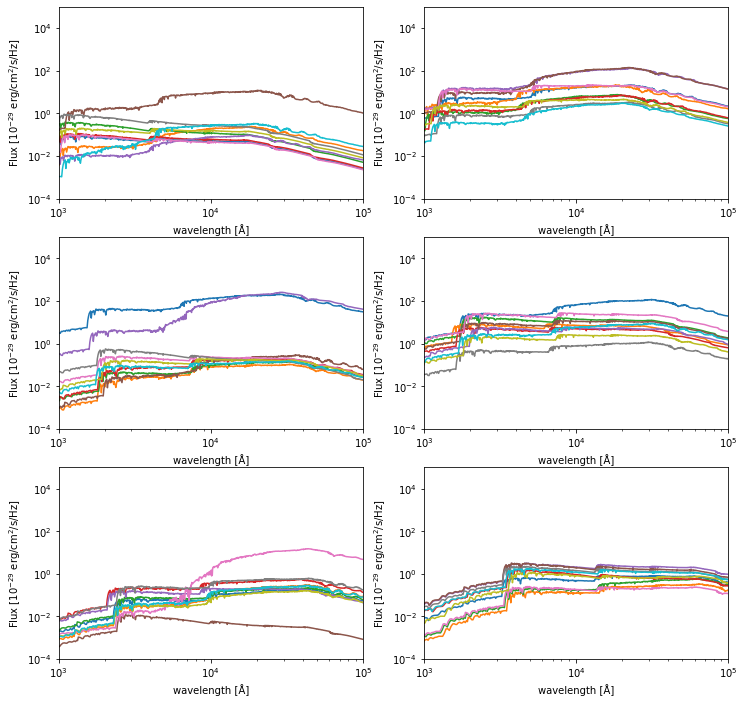

In [87]:
# Euclid + CASTOR worsened populations 

fig, ax = plt.subplots(3, 2, figsize = (12, 12))

for i,id in enumerate(Euclid_lo_z_bad):
    plot_sed(id, ax[0,0])

for i,id in enumerate(Euclid_mid_z_bad):
    plot_sed(id, ax[1,0])

for i,id in enumerate(Euclid_hi_z_bad):
    plot_sed(id, ax[2,0])


for i,id in enumerate(Euclid_lo_z_good):
    plot_sed(id, ax[0,1])


for i,id in enumerate(Euclid_lm_z_good):
    plot_sed(id, ax[1,1])


# for i,id in enumerate(Euclid_hm_z_good):
#     plot_sed(id, ax)
# plt.title('Euclid mid high z good sample')

for i,id in enumerate(Euclid_hi_z_good):
    plot_sed(id, ax[2,1])
# plt.title('Euclid high z good sample')

# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(1000,100000)
# plt.ylim(ymin,ymax)

#     # plt.ylim(ymin,ymax)
# plt.xlabel('wavelength [Å]')

# plt.ylabel('Flux [$10^{-29}$ erg/cm$^2$/s/Hz]')

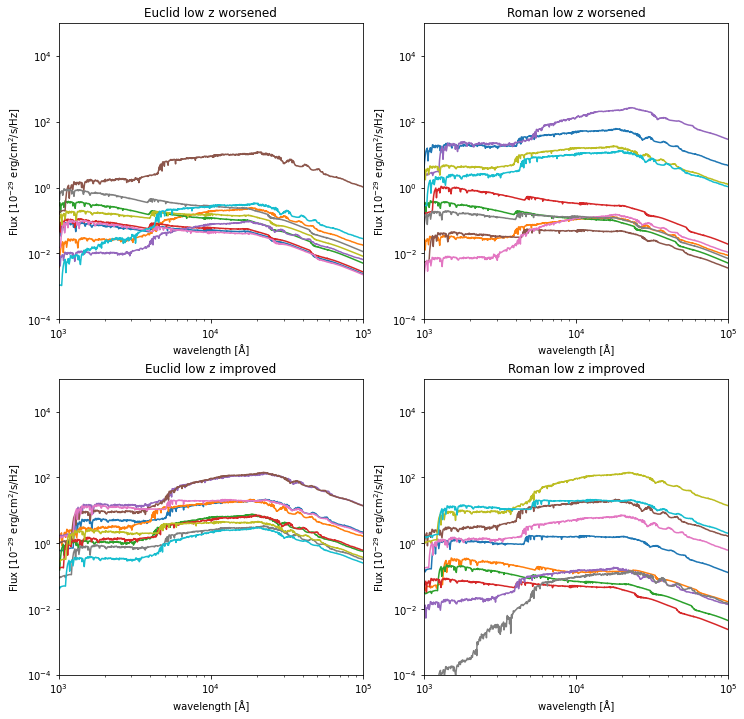

In [96]:
fig, ax = plt.subplots(2, 2, figsize = (12, 12))

for i,id in enumerate(Euclid_lo_z_bad):
    plot_sed(id, ax[0,0])
    ax[0,0].set_title('Euclid low z worsened')

for i,id in enumerate(Roman_lo_z_bad):
    plot_sed(id, ax[0,1])
    ax[0,1].set_title('Roman low z worsened')

for i,id in enumerate(Euclid_lo_z_good):
    plot_sed(id, ax[1,0])
    ax[1,0].set_title('Euclid low z improved')

for i,id in enumerate(Roman_lo_z_good): 
    plot_sed(id, ax[1,1])
    ax[1,1].set_title('Roman low z improved')

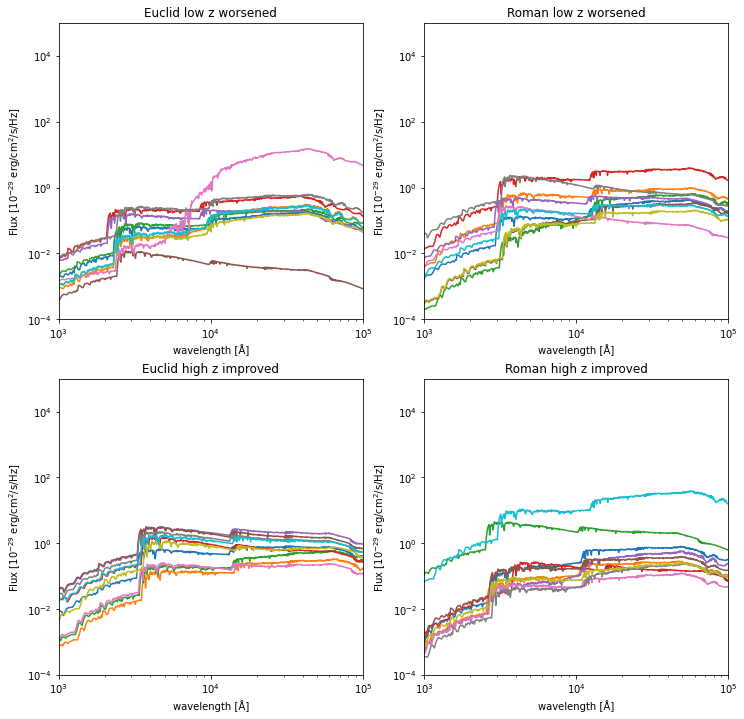

In [104]:
fig, ax = plt.subplots(2, 2, figsize = (12, 12))

for i,id in enumerate(Euclid_hi_z_bad):
    plot_sed(id, ax[0,0])
    ax[0,0].set_title('Euclid low z worsened')

for i,id in enumerate(Roman_hi_z_bad):
    plot_sed(id, ax[0,1])
    ax[0,1].set_title('Roman low z worsened')

for i,id in enumerate(Euclid_hi_z_good):
    plot_sed(id, ax[1,0])
    ax[1,0].set_title('Euclid high z improved')

for i,id in enumerate(Roman_high_z_good): 
    plot_sed(id, ax[1,1])
    ax[1,1].set_title('Roman high z improved')

In [59]:
Euclid_lo_z_good = [391,    470,    493,    583,    681,    692,    711,   1104,   1204, 1594]
Euclid_lm_z_good = [1587,   2283,   2542,   2713,   3086,   3406,   3444,   3700,   3896, 4728]
Euclid_hm_z_good = [2541,   5219,  10656,  10900,  14477,  14967,  16945,  18233,  19702, 21889]
Euclid_hi_z_good = [1257,   1628,   5942,  19892,  22368,  24206,  24584,  25195,  29567, 30049]

Text(0.5, 1.0, 'Euclid high z good sample')

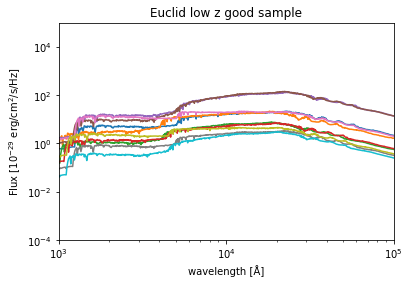

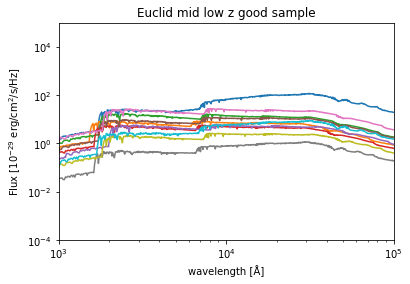

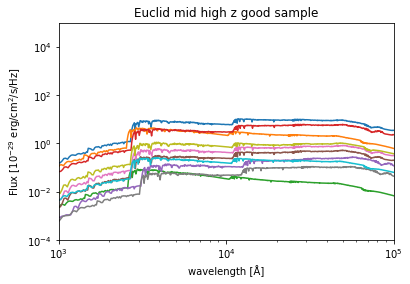

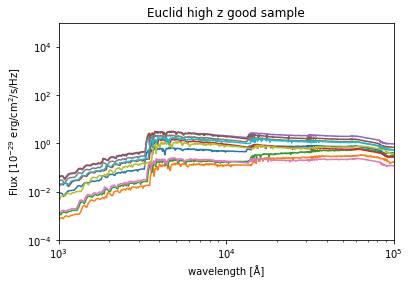

In [98]:
# Euclid + CASTOR good populations

fig, ax = plt.subplots()

for i,id in enumerate(Euclid_lo_z_good):
    plot_sed(id, ax)
plt.title('Euclid low z good sample')

fig, ax = plt.subplots()

for i,id in enumerate(Euclid_lm_z_good):
    plot_sed(id, ax)
plt.title('Euclid mid low z good sample')

fig, ax = plt.subplots()

for i,id in enumerate(Euclid_hm_z_good):
    plot_sed(id, ax)
plt.title('Euclid mid high z good sample')

fig, ax = plt.subplots()

for i,id in enumerate(Euclid_hi_z_good):
    plot_sed(id, ax)
plt.title('Euclid high z good sample')

In [101]:
Roman_lo_z_bad = [1499,   6185,   6322,  14116,  21133,  44157,  61158,  84745,  91326,
        93355]
Roman_hi_z_bad = [2385,   5872,   9150,   9377,  11107,  15617,  26312,  27105,  27843,
        31085] 

Text(0.5, 1.0, 'Roman high z bad sample')

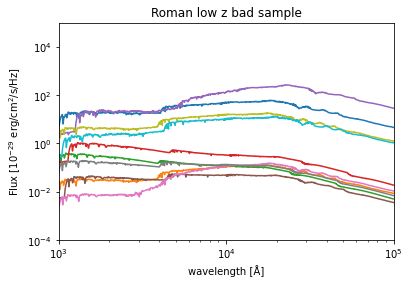

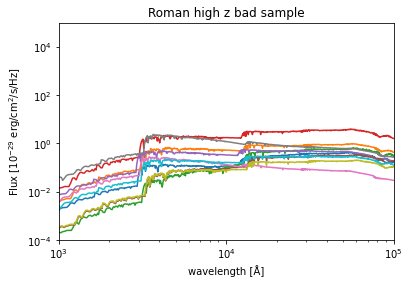

In [102]:
# Roman + CASTOR worsened populations 

fig, ax = plt.subplots()

for i,id in enumerate(Roman_lo_z_bad):
    plot_sed(id, ax)
plt.title('Roman low z bad sample')

fig, ax = plt.subplots()

for i,id in enumerate(Roman_hi_z_bad):
    plot_sed(id, ax)
plt.title('Roman high z bad sample')

In [68]:
Roman_lo_z_good = [3,     51,    132,    147,    200,    470,    583,    656,    692,
          711] 
Roman_mid_z_good = [7385,   8522,  10575,  19900,  30086,  34418,  34867,  39330,  42191,
        49076]
Roman_high_z_good = [538,   1964,   5219,   7488,   8197,   8396,   8856,  11583,  11763,
        11970] 

Text(0.5, 1.0, 'Roman high z good sample')

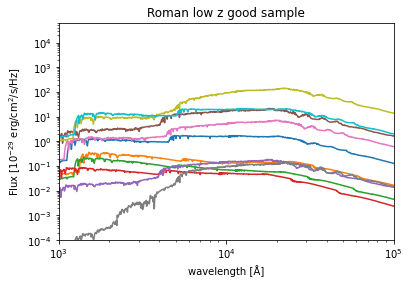

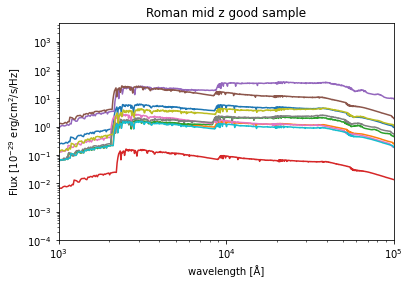

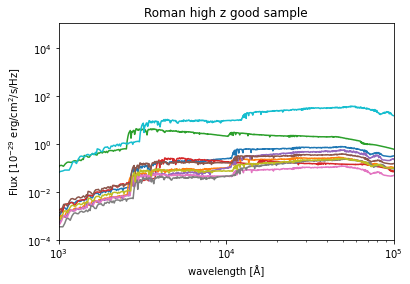

In [69]:
# Roman + CASTOR worsened populations 

fig, ax = plt.subplots()

for i,id in enumerate(Roman_lo_z_good):
    plot_sed(id, ax)
plt.title('Roman low z good sample')

fig, ax = plt.subplots()

for i,id in enumerate(Roman_mid_z_good):
    plot_sed(id, ax)
plt.title('Roman mid z good sample')

fig, ax = plt.subplots()

for i,id in enumerate(Roman_high_z_good):
    plot_sed(id, ax)
plt.title('Roman high z good sample')

In [26]:
# top_ten_worst = np.array([ 83096,  69531,   1793,  62608,  78238, 106407,   6839,
#         95706,  84208,   86967,   68887,  53512])

#

top_ten_worst = np.array([280941])

10
The COSMOS fitted model is model number 10
The offset applied is 1870239.541136415 and a redshift of 0.7462


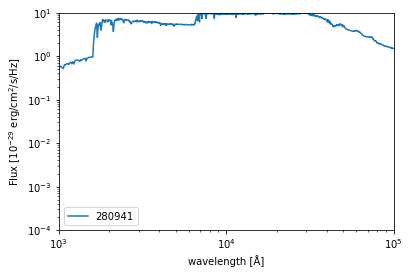

In [27]:
worst_list = []

for ID in top_ten_worst:

  id_gal = ID # the ID number of the galaxy you want to plot; IDs are different for Farmer and Classic
  nid = np.where(cat['ID']==id_gal)[0][0]



  plt.ylabel('Flux [$10^{-29}$ erg/cm$^2$/s/Hz]')

  zp = cat['photoz'][nid]
  m = int(cat['lp_model'][nid])
  print(m)
  wvl = hdf['/model{}/spectra'.format(m)].attrs['lambda[AA]'] *u.AA
  t = np.abs(hdf['/model{}'.format(m)].attrs['age']-cat['lp_age'][nid]).argmin()
  flam_mod = hdf['/model{}/spectra'.format(m)][t,:] *u.erg/u.cm/u.cm/u.s/u.AA
  fnu_mod = flam_mod*(wvl**2)/const.c 

  worst_list.append([wvl.value, flam_mod.value])


# Calculates the flux in units of [uJy] also applying dust ext
# fnu_mod = fnu_mod.to(u.erg/u.cm/u.cm/u.s/u.Hz) * dust_ext(wvl.value,law=cat['lp_Attenuation'][nid],ebv=cat['lp_dust'][nid])
# Rescale the template
  mscal = hdf['/model{}'.format(m)].attrs['mass'][t]/10**cat['lp_mass_best'][nid]  # luminosity/mass resc
  dm = cosmo.luminosity_distance(zp)/(10*u.pc)  # distance modulus
  offset = dm.decompose()**2*mscal/(1+zp) # all together * (1+z) factor

# IGM absorption
# IGM_prescription = igm.Inoue14()
# IGM_abs = IGM_prescription.full_IGM(zp, wvl.value * (1 + zp))

# Plot the best-fit model
  plt.plot(wvl*(1+zp),fnu_mod.to(u.uJy).value/offset, alpha=1,label=ID,zorder=1)
# plt.plot(wvl*(1+zp),fnu_mod.to(u.uJy).value/offset * IGM_abs,color='blue',alpha=1,label='model',zorder=1)

  ymin = 1e-4
  ymax = 1e1

# Show where nebular emission lines would potentially boost the flux
# plt.vlines(3727*(1+zp),ymin,ymax,label='[OII]',zorder=0,color='0.3',ls=':')
# plt.vlines(5007*(1+zp),ymin,ymax,label='[OIII]b',zorder=0,color='0.3',ls=':')
# plt.vlines(4861*(1+zp),ymin,ymax,label='Hb',zorder=0,color='0.3',ls=':') # H_beta
# plt.vlines(6563*(1+zp),ymin,ymax,label='Ha',zorder=0,color='0.3',ls=':') # H_alpha


  plt.xscale('log')
  plt.yscale('log')
  plt.xlim(1000,100000)
  plt.ylim(ymin,ymax)

# plt.ylim(ymin,ymax)
  plt.xlabel('wavelength [Å]')


  print("The COSMOS fitted model is model number",m)
  print('The offset applied is',offset,'and a redshift of',zp)


  plt.legend()


plt.show()

In [24]:
np.save('cluster_center_worst.npy', worst_list)

In [25]:
pwd

'/Users/bryan/Downloads'

In [72]:
top_ten_best = np.array([16435,  90335,   62166,  22684,  12803,
        32036,  54643,  31865,  96186])

3
The COSMOS fitted model is model number 3
The offset applied is 516544965.5298596 and a redshift of 1.1638
1
The COSMOS fitted model is model number 1
The offset applied is 393909909.01005906 and a redshift of 1.0418
12
The COSMOS fitted model is model number 12
The offset applied is 143705625.61778635 and a redshift of 1.9754
9
The COSMOS fitted model is model number 9
The offset applied is 268811729.83356583 and a redshift of 0.1081
2
The COSMOS fitted model is model number 2
The offset applied is 81184352.24924123 and a redshift of 0.9198
5
The COSMOS fitted model is model number 5
The offset applied is 461755812.93780106 and a redshift of 1.0952
2
The COSMOS fitted model is model number 2
The offset applied is 566194554.1142169 and a redshift of 0.2019
10
The COSMOS fitted model is model number 10
The offset applied is 4818988.58683917 and a redshift of 4.9735
5
The COSMOS fitted model is model number 5
The offset applied is 26949349.37283977 and a redshift of 2.6908


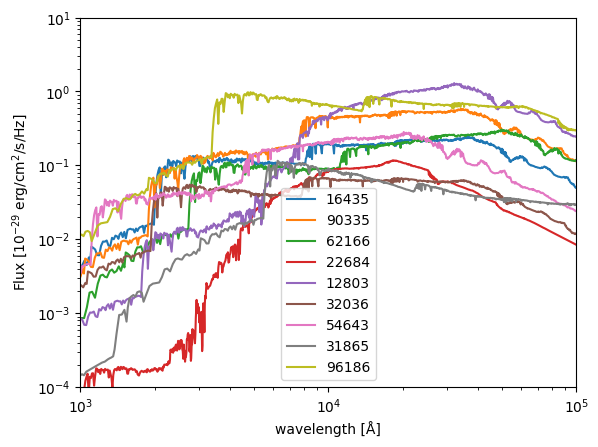

In [73]:
for ID in top_ten_best:

  id_gal = ID # the ID number of the galaxy you want to plot; IDs are different for Farmer and Classic
  nid = np.where(cat['ID']==id_gal)[0][0]



  plt.ylabel('Flux [$10^{-29}$ erg/cm$^2$/s/Hz]')

  zp = cat['photoz'][nid]
  m = int(cat['lp_model'][nid])
  print(m)
  wvl = hdf['/model{}/spectra'.format(m)].attrs['lambda[AA]'] *u.AA
  t = np.abs(hdf['/model{}'.format(m)].attrs['age']-cat['lp_age'][nid]).argmin()
  flam_mod = hdf['/model{}/spectra'.format(m)][t,:] *u.erg/u.cm/u.cm/u.s/u.AA
  fnu_mod = flam_mod*(wvl**2)/const.c
# Calculates the flux in units of [uJy] also applying dust ext
# fnu_mod = fnu_mod.to(u.erg/u.cm/u.cm/u.s/u.Hz) * dust_ext(wvl.value,law=cat['lp_Attenuation'][nid],ebv=cat['lp_dust'][nid])
# Rescale the template
  mscal = hdf['/model{}'.format(m)].attrs['mass'][t]/10**cat['lp_mass_best'][nid]  # luminosity/mass resc
  dm = cosmo.luminosity_distance(zp)/(10*u.pc)  # distance modulus
  offset = dm.decompose()**2*mscal/(1+zp) # all together * (1+z) factor

# IGM absorption
# IGM_prescription = igm.Inoue14()
# IGM_abs = IGM_prescription.full_IGM(zp, wvl.value * (1 + zp))

# Plot the best-fit model
  plt.plot(wvl*(1+zp),fnu_mod.to(u.uJy).value/offset, alpha=1,label=ID,zorder=1)
# plt.plot(wvl*(1+zp),fnu_mod.to(u.uJy).value/offset * IGM_abs,color='blue',alpha=1,label='model',zorder=1)

  ymin = 1e-4
  ymax = 1e1

# Show where nebular emission lines would potentially boost the flux
# plt.vlines(3727*(1+zp),ymin,ymax,label='[OII]',zorder=0,color='0.3',ls=':')
# plt.vlines(5007*(1+zp),ymin,ymax,label='[OIII]b',zorder=0,color='0.3',ls=':')
# plt.vlines(4861*(1+zp),ymin,ymax,label='Hb',zorder=0,color='0.3',ls=':') # H_beta
# plt.vlines(6563*(1+zp),ymin,ymax,label='Ha',zorder=0,color='0.3',ls=':') # H_alpha


  plt.xscale('log')
  plt.yscale('log')
  plt.xlim(1000,100000)
  plt.ylim(ymin,ymax)

# plt.ylim(ymin,ymax)
  plt.xlabel('wavelength [Å]')


  print("The COSMOS fitted model is model number",m)
  print('The offset applied is',offset,'and a redshift of',zp)


  plt.legend()


plt.show()

In [ ]:
def getSpectrum(row_id):
    #nid = np.where(cat['ID']==id_gal)[0][0] # can make this faster by just using row number nid
    nid = row_id
    # Using the redshift of best-fit template
    zp = cat['photoz'][nid]
    m = int(cat['lp_model'][nid])
    wvl = hdf['/model{}/spectra'.format(m)].attrs['lambda[AA]'] * u.AA
    t = np.abs(hdf['/model{}'.format(m)].attrs['age'] - cat['lp_age'][nid]).argmin()

    flam_mod = hdf['/model{}/spectra'.format(m)][t,:] * u.erg/u.cm/u.cm/u.s/u.AA
    fnu_mod = flam_mod * (wvl**2) / const.c
    fnu_mod = fnu_mod.to(u.erg/u.cm/u.cm/u.s/u.Hz)

    # Rescale the template
    mscale = hdf['/model{}'.format(m)].attrs['mass'][t] / 10**cat['lp_mass_best'][nid]  # luminosity/mass resc
    dm = cosmo.luminosity_distance(zp) / (10 * u.pc)  # distance modulus
    scale = dm.decompose()**2 * mscale / (1+zp) # all together * (1+z) factor

    # Calculates the flux in units of [uJy] also applying dust ext
    IGM_abs = IGM_prescription.full_IGM(zp, wvl.value * (1 + zp))

    fnu_mod = fnu_mod / scale * IGM_abs * dust_ext(wvl.value,
                                                   law=cat['lp_Attenuation'][nid],
                                                   ebv=cat['lp_dust'][nid])


    flam_mod = fnu_to_flam(fnu_mod, wvl * (1 + zp))[0]

    return(wvl.value * (1 + zp), flam_mod.value)

In [ ]:
def getOffset(new_filter, ref_filter, wl, flam):
    mags = []
    for filt in [new_filter, ref_filter]:
        mags.append(filt.getMag(wl, flam))

    return mags[0] - mags[1]

In [ ]:
def makeMiniCat(newcat, outfile, start=0, end=100, verbose=False):

    for i in range(start, end):
        wl, flam = getSpectrum(i)

        for f in mock_filters:
            f.offsets = {}

            #weighted average of offsets
            numerator = 0
            denominator = 0

            for name in f.nearby:
                g = og_dict[name]
                f.offsets[name] = getOffset(f, g, wl, flam)
                if cat[name+'_MAG'][i] > 0 and np.abs(f.offsets[name]) < 1: # add in check to make sure colours are close
                    numerator += (cat[name+'_MAG'][i] + f.offsets[name]) / cat[name+'_MAGERR'][i]**2
                    denominator += 1 / cat[name+'_MAGERR'][i]**2
            print(f.name, f.offsets)

            if numerator == 0: # ie no matching bands
                if verbose:
                    print("WARNING: " + f.name + " had no matching bands for galaxy " + str(i) +
                          " with id " + str(cat['ID'][i]) + ". Using convolved SED mag.")
                numerator = f.getMag(wl, flam)
                denominator = 1

            newcat[f.name+"_MAG"][i - start] = numerator / denominator

    newcat.write(outfile, overwrite=True)

In [ ]:
newcat = cat.copy()
newcat.keep_columns(['ID','ID_CLASSIC', 'RA','DEC'] +
                    ['photoz','lp_model','lp_age','lp_dust','lp_Attenuation','lp_zq','lp_type','lp_NbFilt']+
                    ['lp_mass_best', 'lp_mass_med', 'lp_SFR_best', 'lp_SFR_med', 'lp_sSFR_best', 'lp_sSFR_med'])
for f in mock_filters:
    newcat[f.name + "_MAG"] = 0.
    newcat[f.name + "_MAGERR"] = 0.

In [ ]:
makeMiniCat(newcat[newcat['ID'] == 361956], "deleteme2.fits", start=0, end=1, verbose=True)

castor_uv {'GALEX_NUV': 0.061960078024753784, 'CFHT_u': 1.6904162038319015}
castor_u {'GALEX_NUV': -1.5349881645279453, 'CFHT_u': 0.09346796127920243, 'HSC_g': 0.11794887491588213}
castor_g {'CFHT_u': -0.02212364048439497, 'HSC_g': 0.0023572731522847334, 'HSC_r': 0.0037070979290803052}
LSST_u {'GALEX_NUV': -1.6285157002436108, 'CFHT_u': -5.957443646309457e-05, 'HSC_g': 0.024421339200216607}
LSST_g {'CFHT_u': -0.024929238785020402, 'HSC_g': -0.00044832514834070025, 'HSC_r': 0.0009014996284548715}
LSST_r {'HSC_g': 0.0008822090837412588, 'HSC_r': 0.0022320338605368306}
LSST_i {'HSC_r': 0.007403566426702923, 'HSC_i': -0.0019603133794419136, 'HSC_z': -0.007277076599436327}
LSST_z {'HSC_i': 0.00428212058727695, 'HSC_z': -0.001034642632717464, 'HSC_y': 0.21282039656337304}
LSST_y {'HSC_z': -0.2028062596324247, 'HSC_y': 0.01104877956366579, 'UVISTA_Y': 0.23012748614225131}
PanStarrs_g {'CFHT_u': -0.027926647390657422, 'HSC_g': -0.00344573375397772, 'HSC_r': -0.002095908977182148}
PanStarrs_r {

In [ ]:
new = Table.read("deleteme2.fits")

In [ ]:
new

ID,RA,DEC,ID_CLASSIC,photoz,lp_type,lp_NbFilt,lp_zq,lp_model,lp_age,lp_dust,lp_Attenuation,lp_mass_med,lp_mass_best,lp_SFR_med,lp_SFR_best,lp_sSFR_med,lp_sSFR_best,castor_uv_MAG,castor_uv_MAGERR,castor_u_MAG,castor_u_MAGERR,castor_g_MAG,castor_g_MAGERR,LSST_u_MAG,LSST_u_MAGERR,LSST_g_MAG,LSST_g_MAGERR,LSST_r_MAG,LSST_r_MAGERR,LSST_i_MAG,LSST_i_MAGERR,LSST_z_MAG,LSST_z_MAGERR,LSST_y_MAG,LSST_y_MAGERR,PanStarrs_g_MAG,PanStarrs_g_MAGERR,PanStarrs_r_MAG,PanStarrs_r_MAGERR,PanStarrs_i_MAG,PanStarrs_i_MAGERR,PanStarrs_z_MAG,PanStarrs_z_MAGERR,PanStarrs_y_MAG,PanStarrs_y_MAGERR,Euclid_Y_MAG,Euclid_Y_MAGERR,Euclid_J_MAG,Euclid_J_MAGERR,Euclid_H_MAG,Euclid_H_MAGERR,Euclid_VIS_MAG,Euclid_VIS_MAGERR,Roman_062_MAG,Roman_062_MAGERR,Roman_087_MAG,Roman_087_MAGERR,Roman_106_MAG,Roman_106_MAGERR,Roman_129_MAG,Roman_129_MAGERR,Roman_146_MAG,Roman_146_MAGERR,Roman_158_MAG,Roman_158_MAGERR,Roman_184_MAG,Roman_184_MAGERR,Roman_213_MAG,Roman_213_MAGERR
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,float64,float64,int64,float64,int64,int64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
361956,149.8939387291979,2.56768330389507,1209392,1.1322,0,27,2.17,1,321000000.0,0.0,0,8.40478,8.30553,-0.76589,-0.9068,-9.16104,-9.212,27.683381283063973,0.0,26.083222597922745,0.0,25.933979448007204,0.0,25.989695062207076,0.0,25.931173849706575,0.0,25.910131031853247,0.0,25.88632918537942,0.0,25.896767679027413,0.0,25.658279111832258,0.0,25.928176441100934,0.0,25.909296268781667,0.0,25.8861766914551,0.0,25.896642027591362,0.0,25.716326324424212,0.0,25.41168580510678,0.0,25.114985714787608,0.0,25.01849073206723,0.0,25.896338287839622,0.0,25.895286231447123,0.0,25.88796215177956,0.0,25.459552470699105,0.0,25.119364760678536,0.0,25.045045461720687,0.0,25.000617647340757,0.0,25.011155378592104,0.0,25.11887553782062,0.0
